# Pretrain attractor network PCP



## Master config

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE", '\n')
!ls

from misc import model_cfg

cfg = model_cfg(code_name='p_task_v0.03', 
                sample_name='hs04', 
                sample_rng_seed=500,
                hidden_units=150, 
                pho_units=250, 
                cleanup_units=50,
                embed_attractor=None,
                w_oh_noise=0.,   # Noise at weight not implement yet
                w_hp_noise=0.,
                w_pp_noise=0.,
                w_pc_noise=0.,
                w_cp_noise=0.,
                act_p_noise=0., # Noise at activation is OK
                tau=0.2, 
                unit_time=4., 
                n_mil_sample=1., 
                batch_size=64, 
                rnn_activation = 'sigmoid',
                w_initializer = 'glorot_uniform',
                learning_rate=0.005,
                save_freq=5)


GPU is available 

basicOP_master.ipynb  data_wrangling.py  misc.py		__pycache__
custom_layer.ipynb    evaluate.ipynb	 models
custom_layer.py       input		 my_eval.py
data_wrangling.ipynb  misc.ipynb	 pho_task_master.ipynb


# Modeling

## Build model
Fully custom 4-layer recurrent time-averaged input

In [2]:
def buildModel(training=True):
    from tensorflow.keras import Model
    from tensorflow.keras.layers import Layer, Input
    from custom_layer import rnn_pho_task
    from tensorflow.keras.optimizers import Adam

    # Train/test mode checking
    if training is True:
        cfg.w_oh_noise = cfg.w_oh_noise_backup
        cfg.w_hp_noise = cfg.w_hp_noise_backup
        cfg.w_pp_noise = cfg.w_pp_noise_backup
        cfg.w_pc_noise = cfg.w_pc_noise_backup
        cfg.w_cp_noise = cfg.w_cp_noise_backup
        cfg.act_p_noise = cfg.act_p_noise_backup
    else:
        cfg.w_oh_noise = 0
        cfg.w_hp_noise = 0
        cfg.w_pp_noise = 0
        cfg.w_pc_noise = 0
        cfg.w_cp_noise = 0
        cfg.act_p_noise = 0

    input_o = Input(shape=(cfg.pho_units,))
    rnn_model = rnn_pho_task(cfg)(input_o)
    model = Model(input_o, rnn_model)

    adam = Adam(learning_rate=cfg.learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=['BinaryAccuracy', 'mse'])

    model.summary()

    return model

model = buildModel(training=True)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
rnn_pho_task (rnn_pho_task)  [(None, 250), (None, 250) 162950    
Total params: 162,950
Trainable params: 87,800
Non-trainable params: 75,150
_________________________________________________________________


## Train model

In [4]:
from keras.callbacks import ModelCheckpoint
from data_wrangling import sampleGenerator
import h5py, pickle, os
from IPython.display import clear_output

from data_wrangling import my_data
data = my_data(cfg)

checkpoint = ModelCheckpoint(cfg.path_weights_checkpoint, verbose=1, 
                             period=cfg.save_freq, save_weights_only=True) 

history = model.fit(sampleGenerator(data.y_train, data.y_train, 
                                    cfg.n_timesteps - 14, cfg.batch_size, 
                                    data.sample_p, cfg.sample_rng_seed),
                                    steps_per_epoch = cfg.steps_per_epoch,
                                    epochs = cfg.nEpo,
                                    verbose=0,  
                                    callbacks=[checkpoint])


# Saving history and model
pickle_out = open(cfg.path_history_pickle,"wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

clear_output()
print('Training done')

Training done


# Reporting

Training history

In [5]:
from my_eval import training_history

hist = training_history(cfg.path_history_pickle)
hist.plot_all(cfg.path_plot_folder + 'history.html')

alt.HConcatChart(...)

Weight matrixs

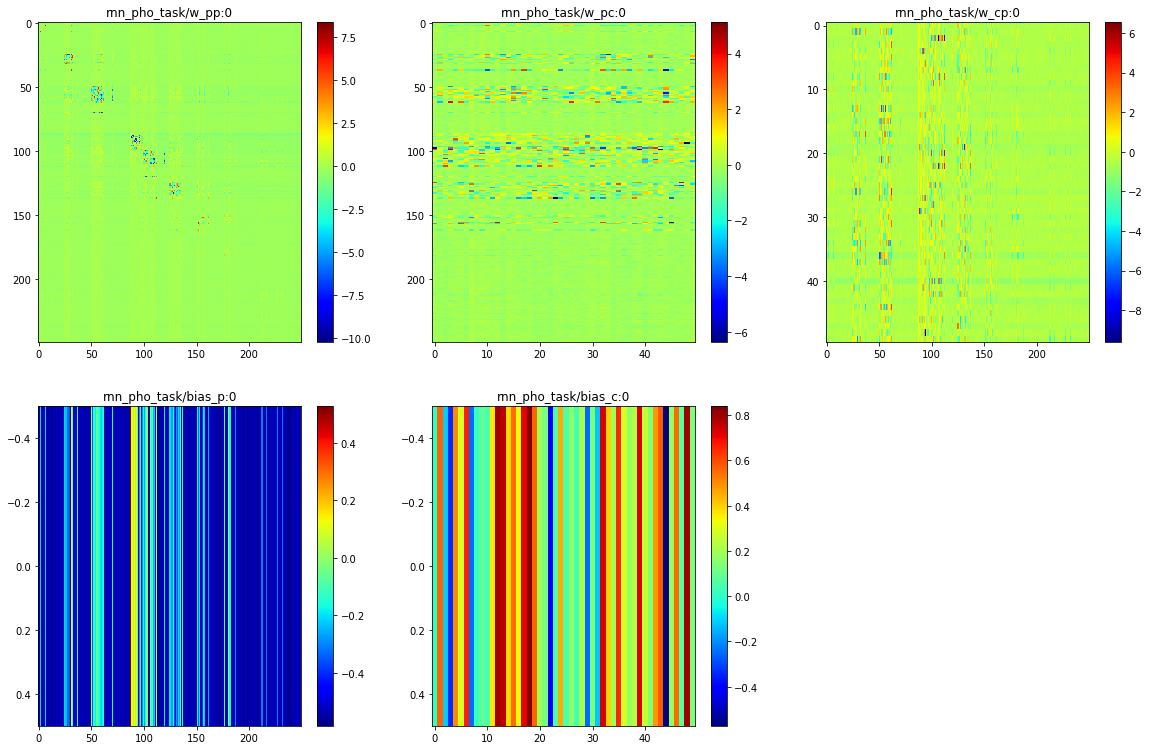

In [6]:
from misc import plot_variables
plot_variables(model)

Prediction

In [8]:
from my_eval import get_all_pronunciations_fast
y_pred_matrix = model.predict(data.y_strain)
y_pred = get_all_pronunciations_fast(y_pred_matrix[-1], data.phon_key)
#y_pred = get_all_pronunciations_fast(y_pred_matrix, data.phon_key)
y_true = get_all_pronunciations_fast(data.y_strain, data.phon_key)

print('\n Y-predicts are: \n')
print(y_pred)
print('\n Y-trues are: \n')
print(y_true)


 Y-predicts are: 

['__bal_____' '__b@nk____' '__biC_____' '__bik_____' '__bird____'
 '__bEd_____' '_blInk____' '_blak_____' '__buT_____' '__bol_____'
 '__baks____' '_brET_____' '_brAb_____' '_brIJ_____' '_brad_____'
 '_brum_____' '__b^nC____' '__keJ_____' '__kek_____' '__kard____'
 '__kEr_____' '__kev_____' '__CEr_____' '__Calk____' '__CAld____'
 '__Cuz_____' '__C^rC____' '_kla______' '_klin_____' '_klWn_____'
 '_klu______' '__kast____' '__kWC_____' '_kras_____' '_kro______'
 '__k^rs____' '__k^t_____' '__d@ns____' '__dil_____' '__dip_____'
 '__dAm_____' '__dag_____' '__d^l_____' '__fes_____' '__f@st____'
 '__falt____' '__fir_____' '__fAn_____' '__fAv_____' '_flor_____'
 '_flut_____' '__fo______' '__fud_____' '__fUt_____' '__fork____'
 '_frel_____' '_frEnd____' '_fr^nt____' '_frast____' '__gen_____'
 '__g@ng____' '__g@sp____' '__g^rl____' '_gl@s_____' '_grin_____'
 '_grif_____' '_grup_____' '__g^n_____' '__halt____' '__harm____'
 '__harp____' '__hest____' '__hEd_____' '__hElT____' '__

In [1]:
!jupyter nbconvert --to html --output-dir=$cfg.path_model_folder attractor.ipynb

[NbConvertApp] Converting notebook attractor.ipynb to html
[NbConvertApp] Writing 681854 bytes to .path_model_folder/attractor.html
